In [1]:
# === Standard libraries ===
import os
from pathlib import Path
import yaml
# === Data handling ===
import pandas as pd
import numpy as np

# === Geospatial processing ===
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import mapping
from shapely.ops import unary_union
from pyproj import Transformer

# === Visualization ===
import matplotlib.pyplot as plt
import contextily as cx

# === Utilities ===
from tqdm import tqdm
from joblib import Parallel, delayed

from scripts.feature_engine.get_tiles_with_regions_and_sites import (
    load_sites_from_df,
    load_main_rivers,
    get_distance_to_rivers_parallel,
    crop_and_plot_by_latitude,
    split_aoi_into_grid,
    generate_tiles_from_buffer,
    tag_tiles_by_geoglyphs,
    tag_and_plot_tiles_region
)

# 📁 Load config paths
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_DIR = Path(config["raw_data_dir"])
PROCESSED_DIR = Path(config["processed_data_dir"])
AOI_CRS = config["aoi_crs"]
METRIC_CRS = config["metric_crs"]

In [2]:
# 📍 Load raw data
sites = pd.read_csv(PROCESSED_DIR / "all_coords.csv")
lidar_csv = pd.read_csv(RAW_DIR / "datasets" / "cms_brazil_lidar_tile_inventory.csv")

# 📌 Step 1: Generate gdf_sites and lidar geometry

# 1.1 Sites GeoDataFrame
gdf_sites = load_sites_from_df(sites, "coordinates", AOI_CRS, METRIC_CRS, None)

# 1.2 LiDAR bounding boxes
lidar_gdf = gpd.GeoDataFrame(
    lidar_csv,
    geometry=lidar_csv.apply(lambda r: box(r.min_lon, r.min_lat, r.max_lon, r.max_lat), axis=1),
    crs=AOI_CRS
).to_crs(METRIC_CRS)

lidar_web = lidar_gdf.copy()
lidar_centroids = lidar_web.copy()
lidar_centroids["geometry"] = lidar_web.geometry.centroid

In [3]:
# 📌 Step 2: Compute AOI bounding box
xmin_s, ymin_s, xmax_s, ymax_s = gdf_sites.total_bounds
xmin_l, ymin_l, xmax_l, ymax_l = lidar_gdf.total_bounds
xmin = min(xmin_s, xmin_l)
ymin = min(ymin_s, ymin_l)
xmax = max(xmax_s, xmax_l)
ymax = max(ymax_s, ymax_l)

from pyproj import Transformer
transformer = Transformer.from_crs(METRIC_CRS, AOI_CRS, always_xy=True)
min_lon, min_lat = transformer.transform(xmin, ymin)
max_lon, max_lat = transformer.transform(xmax, ymax)
AOI_BBOX = (min_lon, min_lat, max_lon, max_lat)

# Re-create gdf_all based on full bbox
gdf_all = load_sites_from_df(sites, "coordinates", AOI_CRS, METRIC_CRS, AOI_BBOX)

In [4]:

# 🌊 Step 3: Load rivers
data_path = RAW_DIR / "datasets" / "hydrorivers-dataset" / "HydroRIVERS.gdb"
main_rivers_web = load_main_rivers(data_path, AOI_BBOX, AOI_CRS, METRIC_CRS)

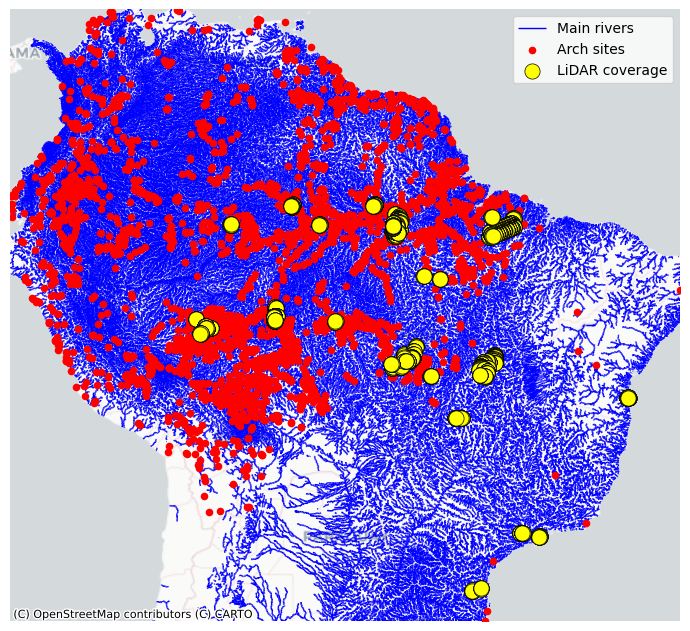

In [5]:
# 🗺️ Step 4: Visualize everything together
main_rivers_web = main_rivers_web.to_crs(METRIC_CRS)
gdf_all_3857 = gdf_all.to_crs(METRIC_CRS)
lidar_centroids = lidar_centroids.to_crs(METRIC_CRS)

fig, ax = plt.subplots(figsize=(7, 7))
main_rivers_web.plot(ax=ax, linewidth=1, color="blue", label="Main rivers", zorder=1)
gdf_all_3857.plot(ax=ax, color="red", markersize=20, label="Arch sites", zorder=2)
lidar_centroids.plot(
    ax=ax,
    marker='o', facecolor='yellow', edgecolor='black',
    linewidth=0.5, markersize=120, alpha=1.0,
    label='LiDAR coverage', zorder=5
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_xlim(*gdf_all_3857.total_bounds[[0, 2]])
ax.set_ylim(*gdf_all_3857.total_bounds[[1, 3]])
ax.set_axis_off()
ax.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

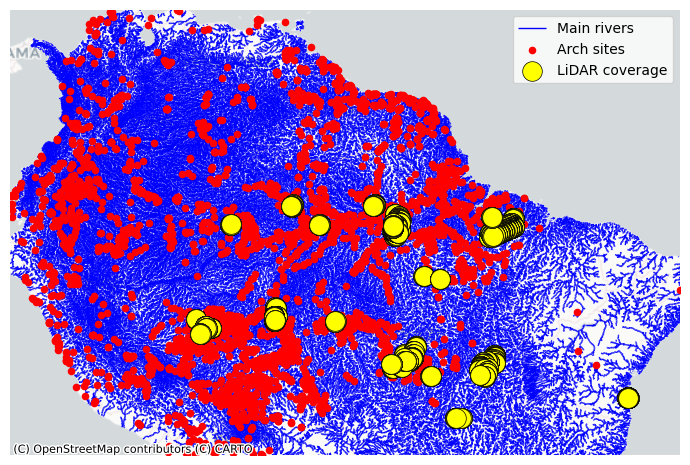

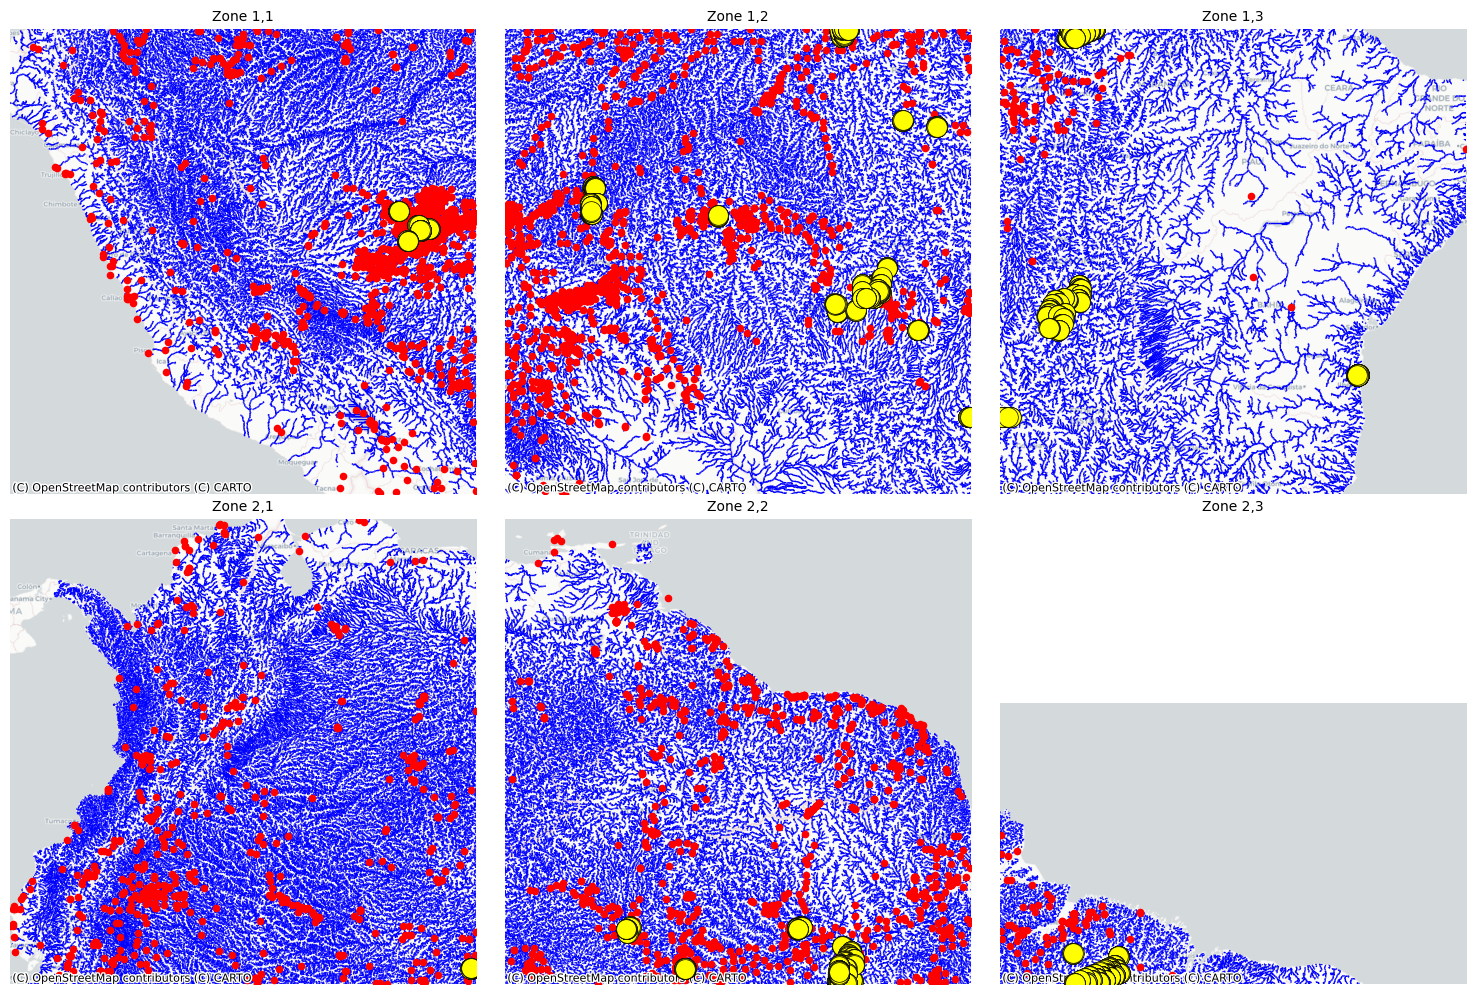

In [6]:
# ➗ Step 5: Crop and split into regions
LAT_CUT = -18.2
rivers_cut, sites_cut, lidar_cut = crop_and_plot_by_latitude(
    main_rivers_web, gdf_all_3857, lidar_centroids, LAT_CUT, figsize=(7, 7)
)

regions = split_aoi_into_grid(
    rivers_cut, sites_cut, lidar_cut,
    n_cols=3, n_rows=2,
    figsize_per_cell=(5, 5)
)

dist-to-river: 100%|██████████| 6167/6167 [00:26<00:00, 234.43it/s]


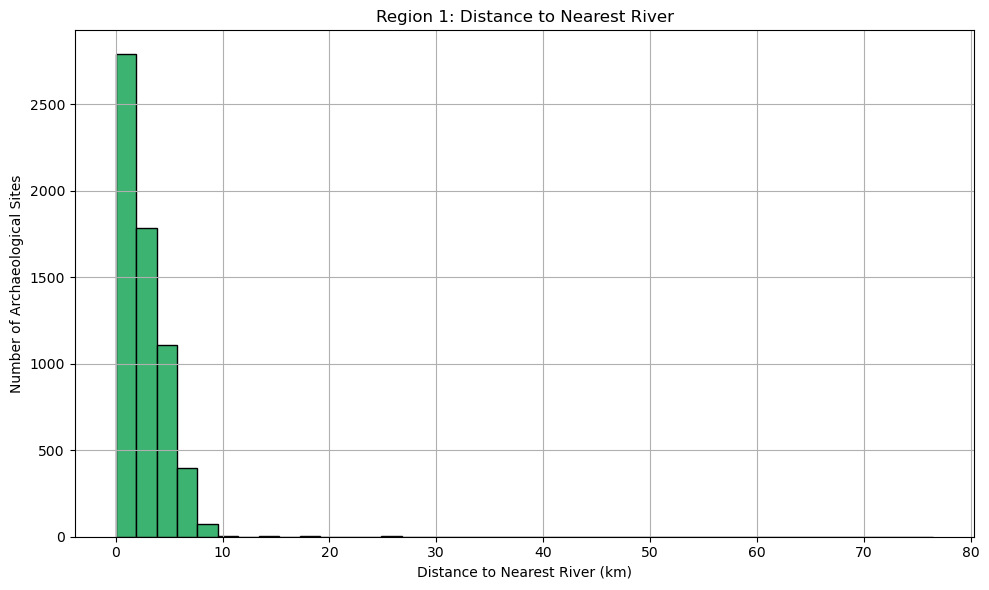

dist-to-river: 100%|██████████| 2159/2159 [00:11<00:00, 188.88it/s]


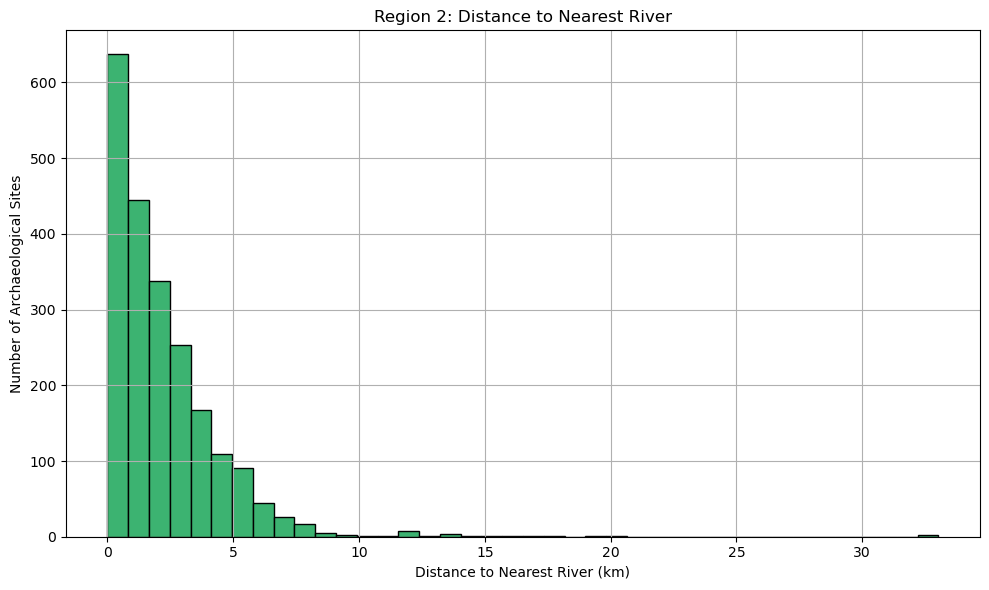

dist-to-river: 100%|██████████| 86/86 [00:00<00:00, 100.86it/s]


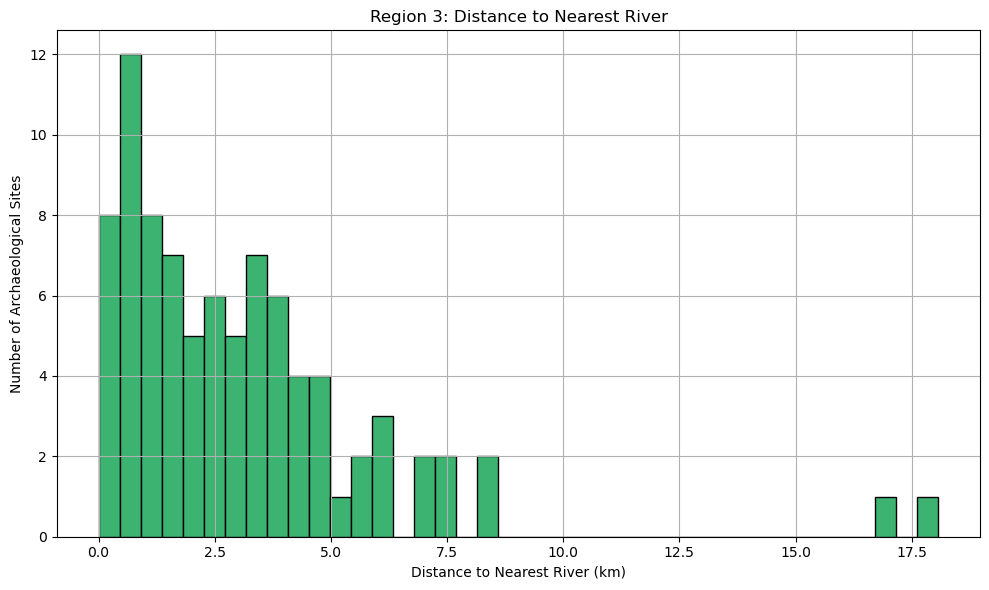

dist-to-river: 100%|██████████| 599/599 [00:06<00:00, 95.18it/s] 


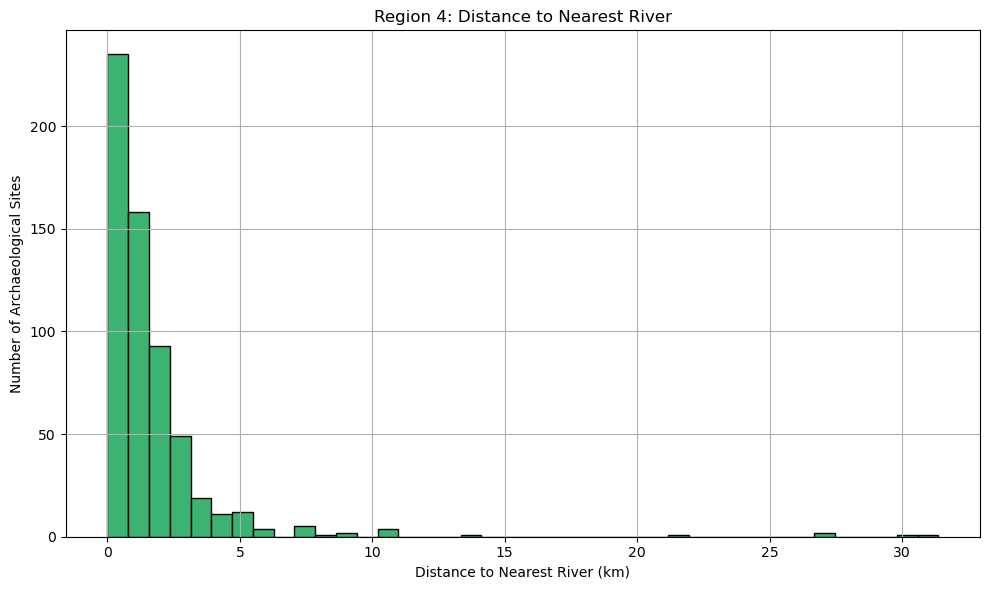

dist-to-river: 100%|██████████| 1333/1333 [00:13<00:00, 101.19it/s]


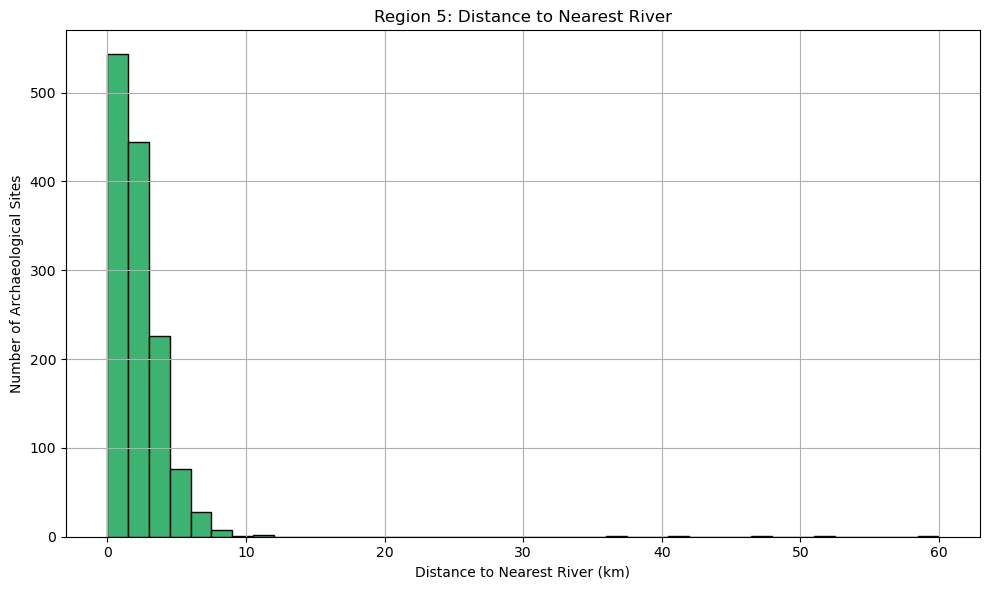

dist-to-river: 100%|██████████| 112/112 [00:01<00:00, 94.48it/s]


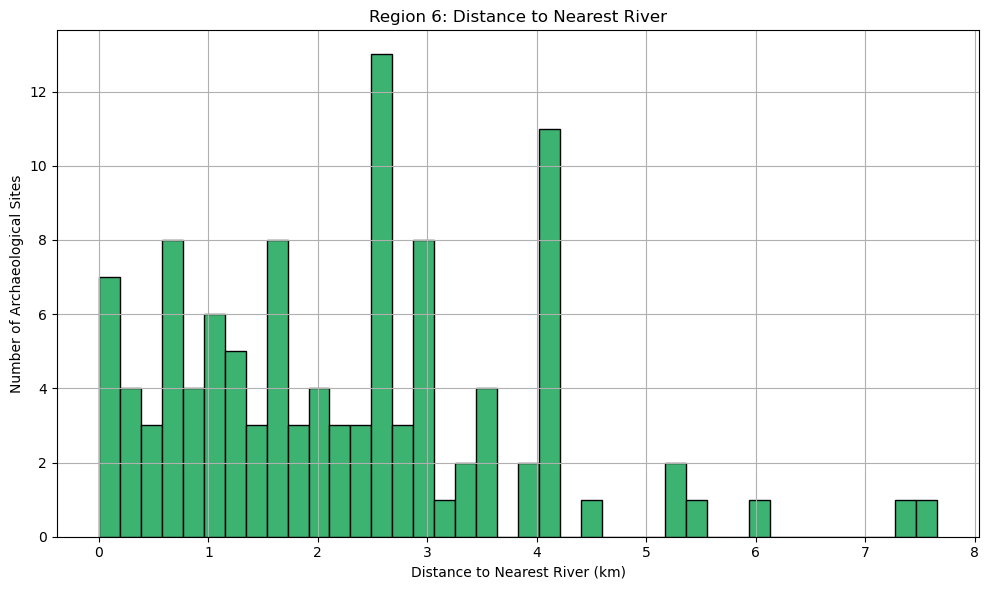

In [7]:

# 📏 Step 6: Compute distances to rivers and plot histograms
regions_with_dist = []
for idx, (r_cells, sites_cells, lidar_cells, bbox) in enumerate(regions, start=1):
    sites_d = get_distance_to_rivers_parallel(sites_cells, main_rivers_web)
    regions_with_dist.append(sites_d)
    plt.figure(figsize=(10, 6))
    plt.hist(sites_d["dist_to_river_m"] / 1000, bins=40, color="mediumseagreen", edgecolor="black")
    plt.xlabel("Distance to Nearest River (km)")
    plt.ylabel("Number of Archaeological Sites")
    plt.title(f"Region {idx}: Distance to Nearest River")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
# 🧱 Step 7: Generate tiles and assign to regions
buffers_9km = main_rivers_web.buffer(9000)
buffers_gdf = gpd.GeoDataFrame(geometry=buffers_9km, crs=METRIC_CRS)
tiles_gdf = generate_tiles_from_buffer(buffers_gdf, AOI_BBOX, AOI_CRS, 9, PROCESSED_DIR / "tiles_9km.gpkg")
tiles_web = tiles_gdf.to_crs(METRIC_CRS)

tiles_web_regions = {}
for idx, (_, _, _, bbox) in enumerate(regions, start=1):
    xmin, ymin, xmax, ymax = bbox
    tiles_reg = tiles_web.cx[xmin:xmax, ymin:ymax].copy()
    tiles_web_regions[f"tiles_web_reg_{idx}"] = tiles_reg

⏳ Generating 324414 potential tiles in parallel...


Latitude bands: 100%|██████████| 538/538 [01:47<00:00,  5.02it/s]


• 203,042 tiles intersect the buffer
✓ Grid written → data/processed/tiles_9km.gpkg


/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")
/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


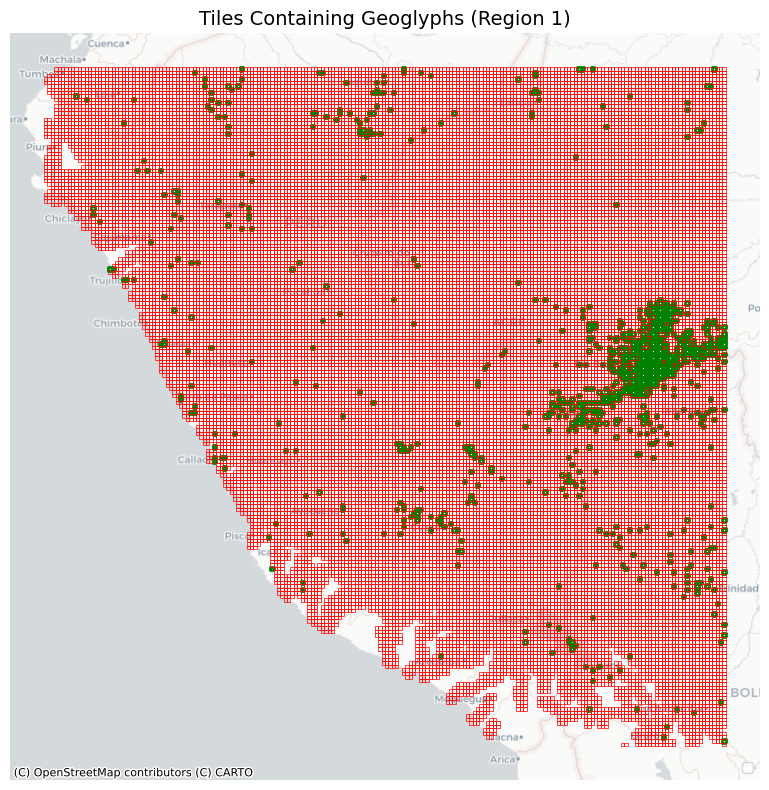

/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")
/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


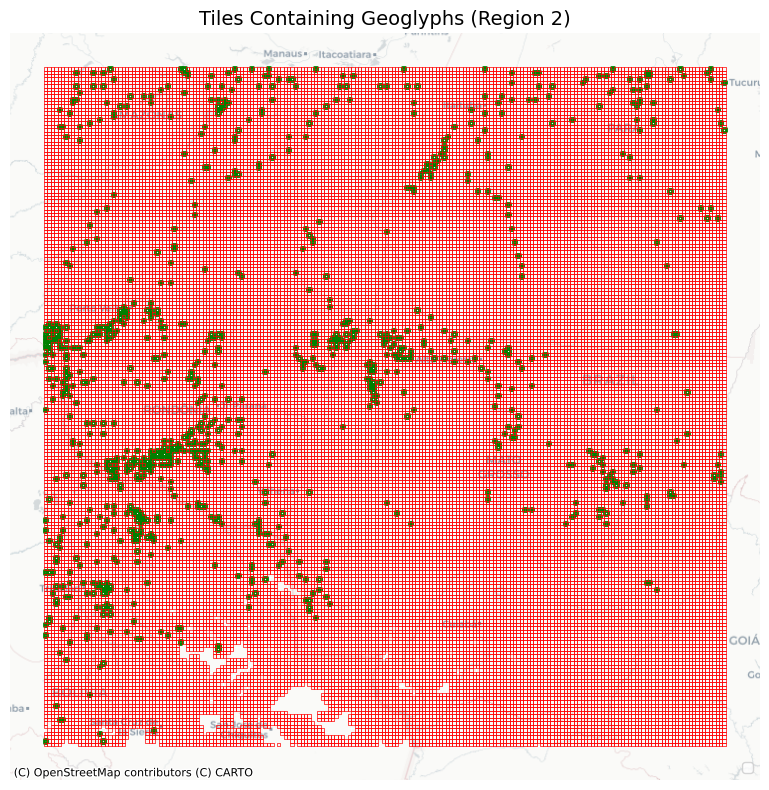

/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")
/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


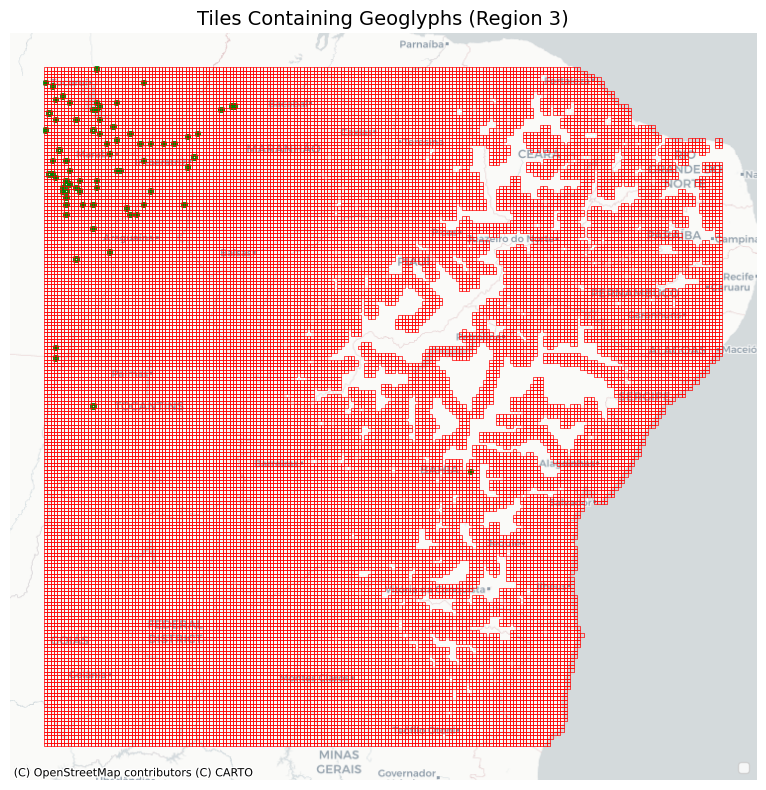

/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")
/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


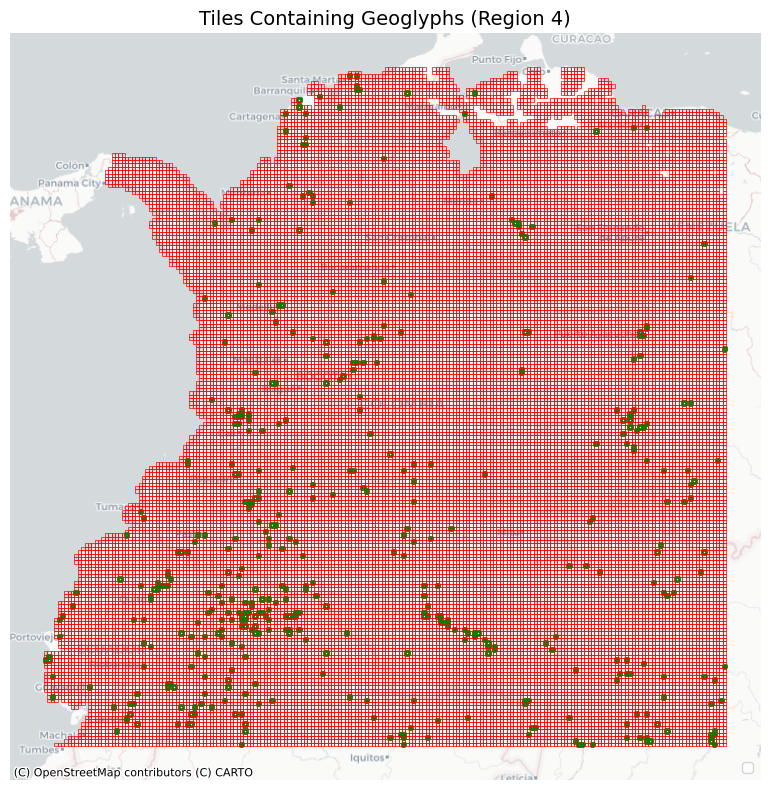

/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")
/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


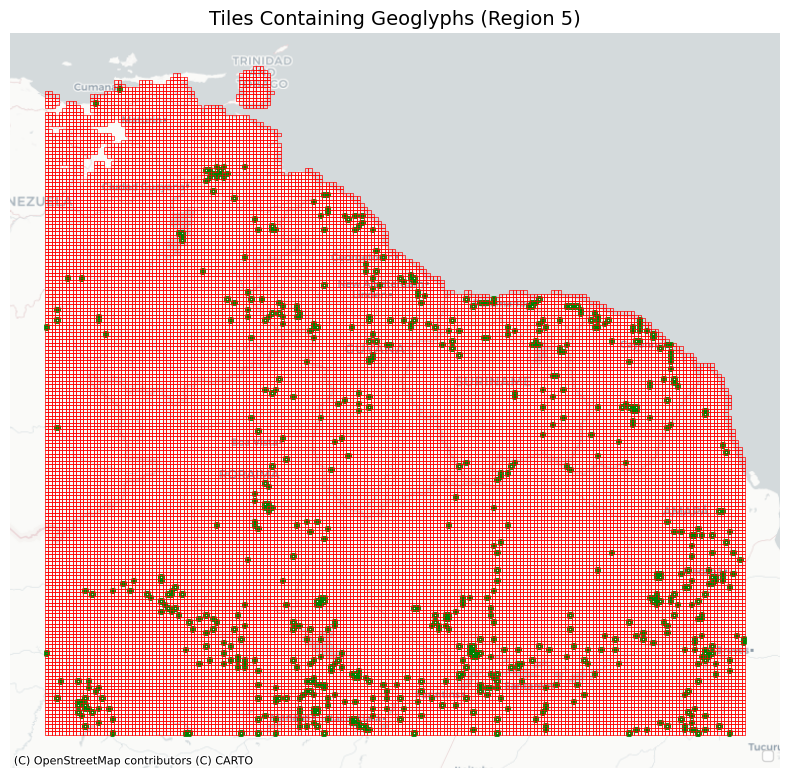

/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right")
/app/scripts/feature_engine/get_tiles_with_regions_and_sites.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


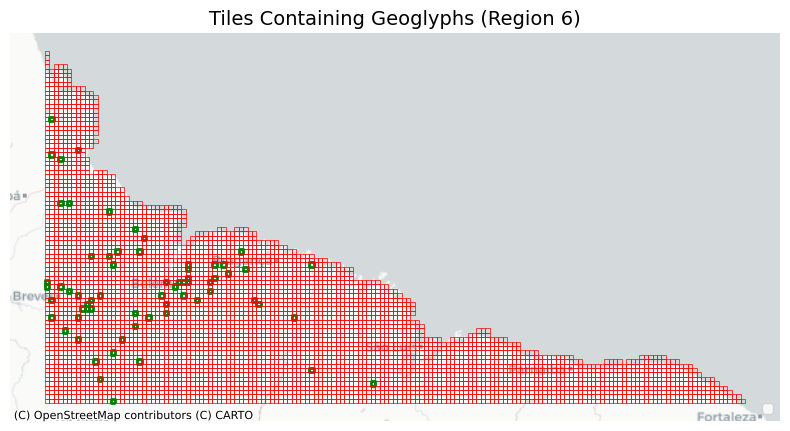

In [9]:
# 🧾 Step 8: Tag and visualize tiles
for i in range(1, 7):
    tag_and_plot_tiles_region(
        tiles_web_regions[f"tiles_web_reg_{i}"],
        gdf_all_3857,
        metric_crs=METRIC_CRS,
        title_suffix=f"(Region {i})"
    )

In [10]:
# ✅ Step 9: Save all tagged regions
for i in range(1, 7):
    tiles = tiles_web_regions[f"tiles_web_reg_{i}"]
    tagged = tag_tiles_by_geoglyphs(tiles, gdf_all_3857)
    out_path = PROCESSED_DIR / f"region_{i}_tagged_with_site.gpkg"
    tagged.to_file(out_path, driver="GPKG")
    print(f"✔ Saved {len(tagged)} tiles → {out_path}")

✔ Saved 29701 tiles → data/processed/region_1_tagged_with_site.gpkg
✔ Saved 39343 tiles → data/processed/region_2_tagged_with_site.gpkg
✔ Saved 31564 tiles → data/processed/region_3_tagged_with_site.gpkg
✔ Saved 32909 tiles → data/processed/region_4_tagged_with_site.gpkg
✔ Saved 29853 tiles → data/processed/region_5_tagged_with_site.gpkg
✔ Saved 4381 tiles → data/processed/region_6_tagged_with_site.gpkg
